ESS and Population Reweighting Analysis

Analyzing CHARMM27_TIP3P...
  Loaded proportions: (5000, 4)
    G3
    G3+
    G5+
    G5+G3
    V1
    V1G3V4
    V1V4
    V4
    WT
  Combined 9/9 isotope error arrays
  Combined error shape: (5000, 1000)
    ESS = 100 at θ = 43.415
  ESS range: [1.00, 4998.72]

Analyzing CHARMM36m_TIP3P...
  Loaded proportions: (5000, 4)


/home/ianjefab/ipykernel_458366/2162913952.py:106: RuntimeWarning: invalid value encountered in divide
  weights = weights / np.sum(weights, axis=0, keepdims=True)


    G3
    G3+
    G5+
    G5+G3
    V1
    V1G3V4
    V1V4
    V4
    WT
  Combined 9/9 isotope error arrays
  Combined error shape: (5000, 1000)
    ESS = 100 at θ = 64.985
  ESS range: [1.00, 4999.70]

Creating reweighting analysis figure...


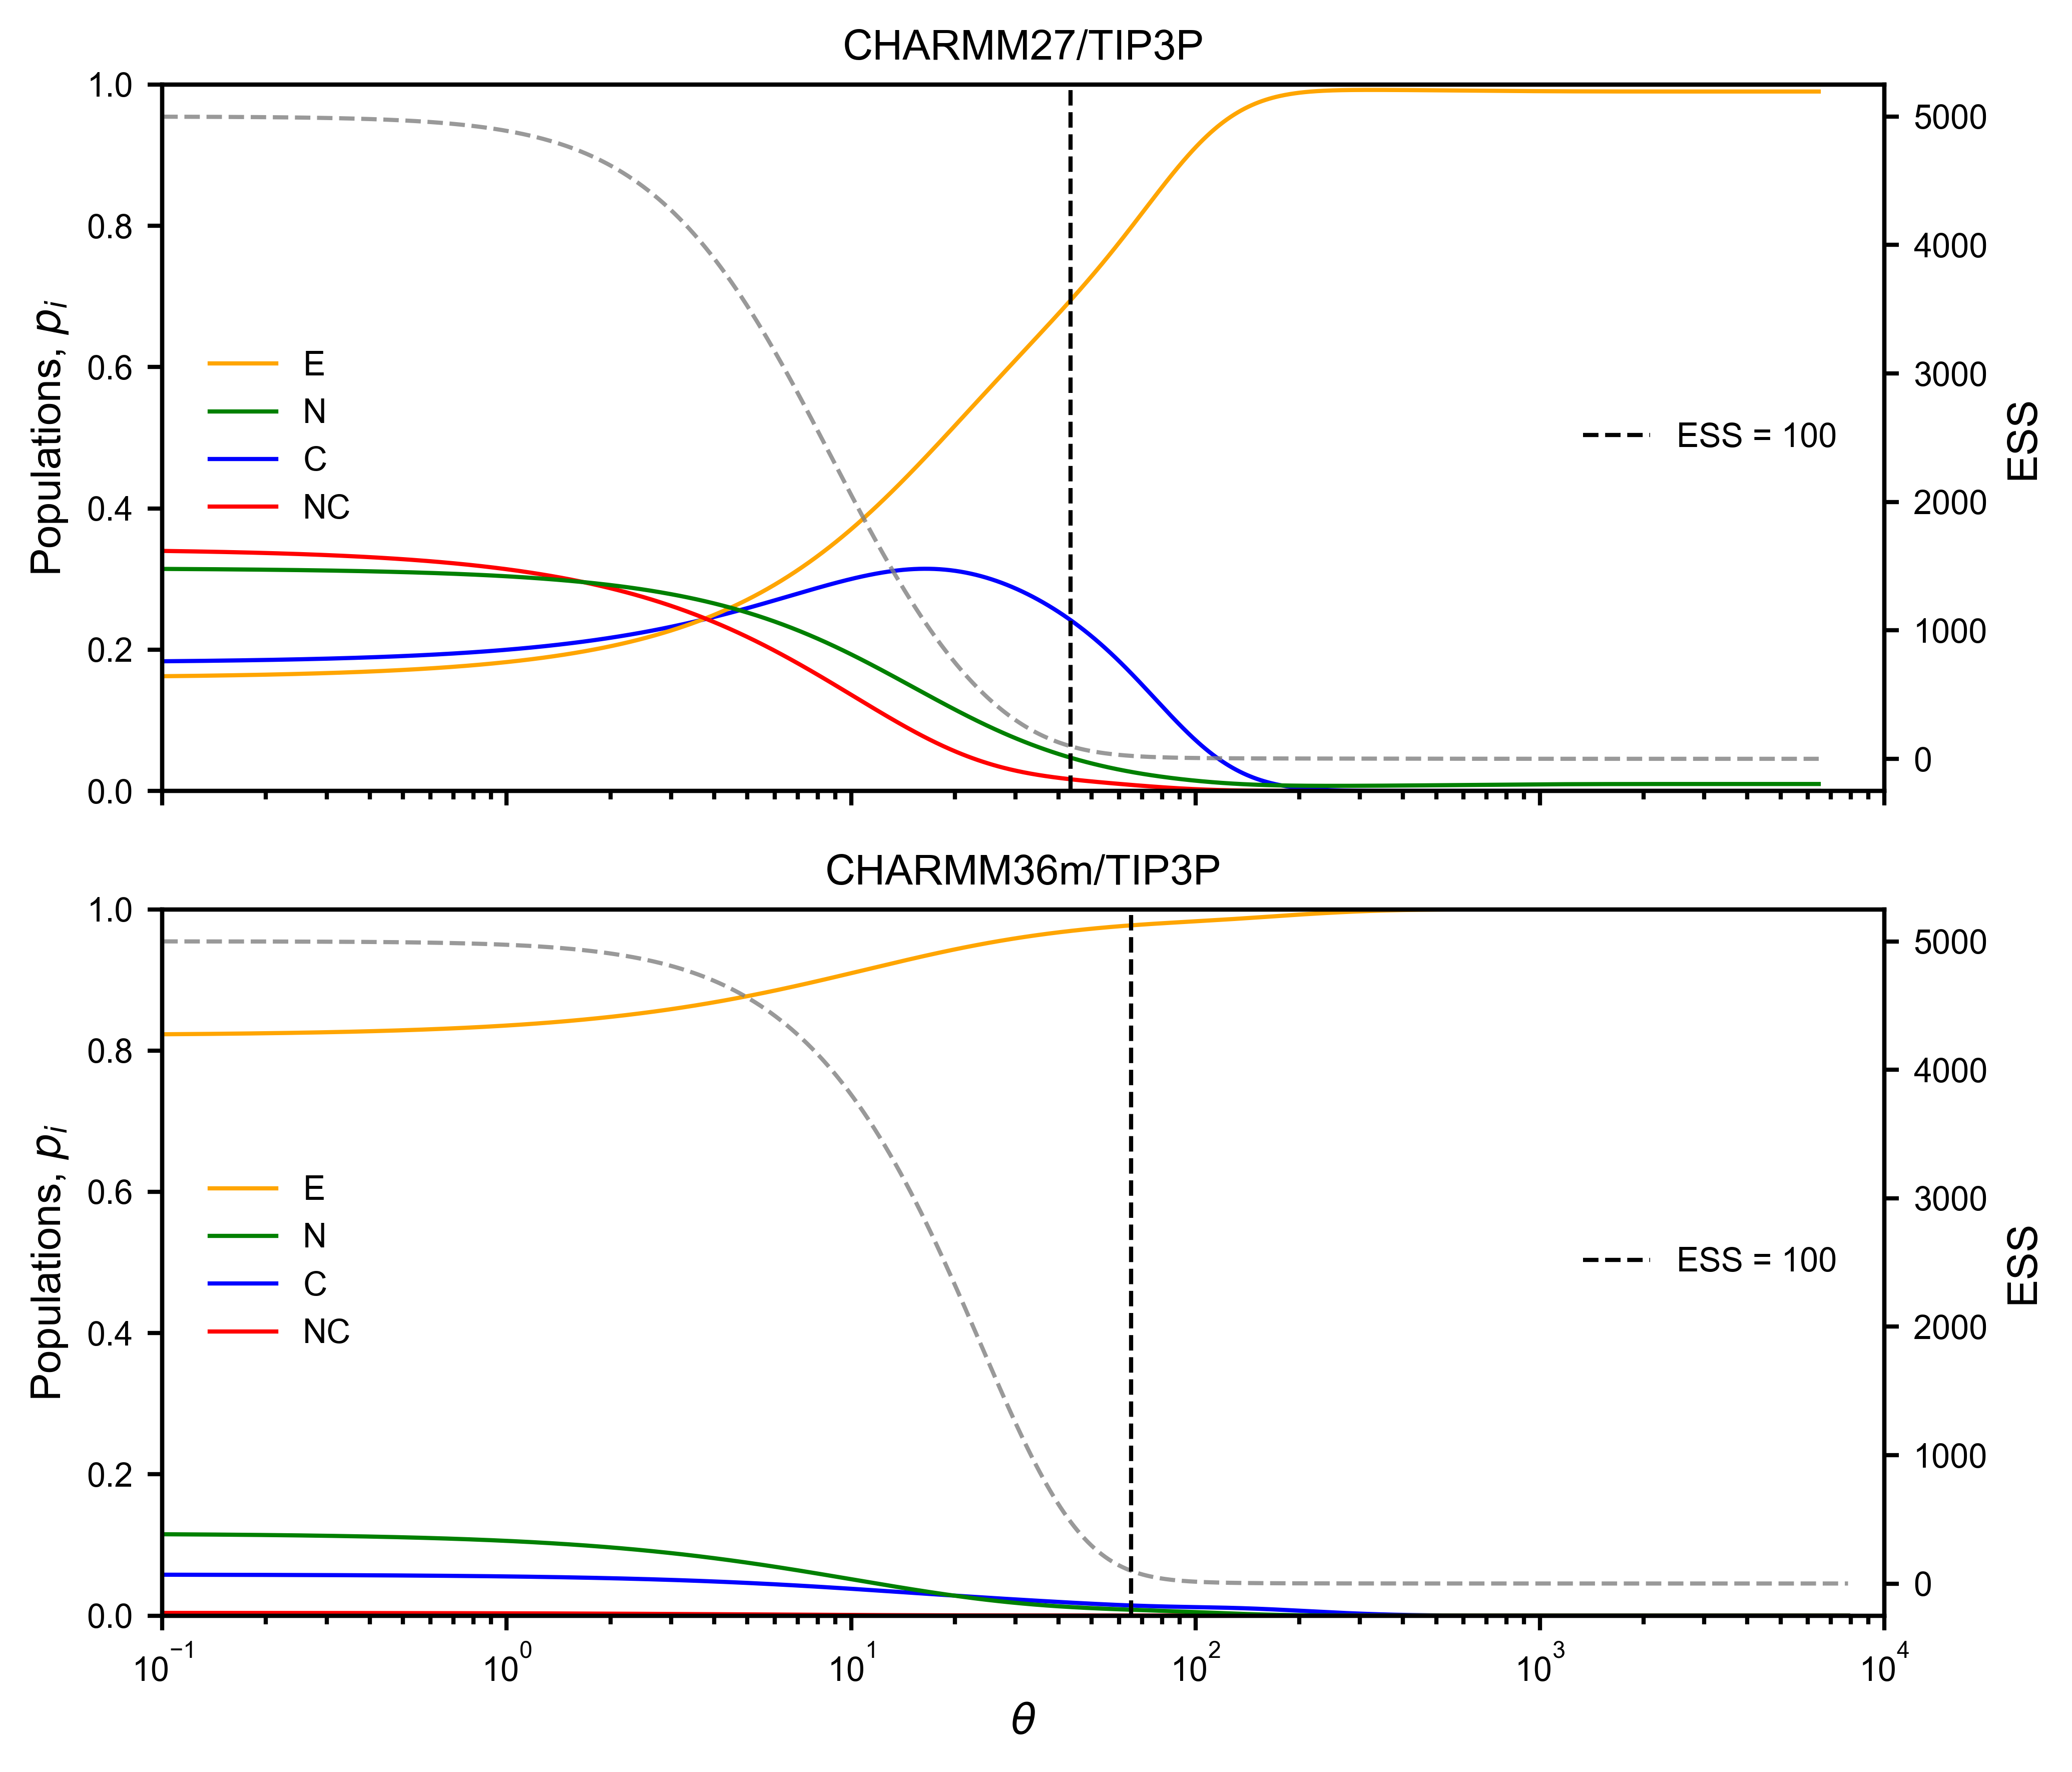


Reweighting analysis completed successfully!


In [1]:
### POPULATIONS FOR GLOBAL REFINEMENT AS A FUNCTION OF \THETA (FIG S09) ###
### 2 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
ERROR_DIR = BASE_DIR / 'error_data' / 'overlap_full'
PROP_DIR = BASE_DIR / 'prop_array'

# Data Specifications
FORCE_FIELDS = ['CHARMM27_TIP3P', 'CHARMM36m_TIP3P']
FORCE_FIELD_LABELS = {
    'CHARMM27_TIP3P': 'CHARMM27/TIP3P',
    'CHARMM36m_TIP3P': 'CHARMM36m/TIP3P'
}

ISOTOPES = ['G3', 'G3+', 'G5+', 'G5+G3', 'V1', 'V1G3V4', 'V1V4', 'V4', 'WT']

# State definitions
STATE_KEYS = ['C', 'E', 'NC', 'N']
STATE_COLORS = {'C': 'blue', 'E': 'orange', 'NC': 'red', 'N': 'green'}
STATE_PLOT_ORDER = ['E', 'N', 'C', 'NC']

# Analysis Parameters
SHIFT = 0
THETA_RANGE = np.logspace(-1, 4, 1000)
ESS_TARGET = 100

# Plotting Specifications
FIGURE_SIZE = (7, 6)
DPI = 600
ESS_COLOR = 'grey'
ESS_TARGET_COLOR = 'black'

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_proportions_array(force_field):
    """
    Args:
        force_field (str): Either 'CHARMM27_TIP3P' or 'CHARMM36m_TIP3P'
    Returns:
        proportions (numpy array): Shape (5000, 4)
        - n_frames = number of simulation time points
        - 4 = number of states [C, E, NC, N]
        - Each row sums to 1.0 (probabilities)
        - Example: [[0.2, 0.3, 0.1, 0.4],  # Frame 1: 20% C, 30% E, 10% NC, 40% N
        -           [0.1, 0.4, 0.2, 0.3]]   # Frame 2: different proportions
    """
    filepath = PROP_DIR / force_field / f'proportions_array_0100ps_{force_field}_PAPER.npy'
    
    if not filepath.exists():
        raise FileNotFoundError(f'Missing proportions file: {filepath}')
    
    proportions = np.load(filepath)
    print(f'  Loaded proportions: {proportions.shape}')
    
    return proportions

def load_combined_error_data(force_field):
    """Load and combine error data from all isotope variants."""
    combined_error = None
    loaded_count = 0
    
    for isotope in ISOTOPES:
        filename = f'error_overlap_{isotope}_{force_field}_ch27_{SHIFT}.npy' # Shape: (5000, 1000)
        filepath = ERROR_DIR / filename
        
        if filepath.exists():
            error_data = np.load(filepath)
            
            if combined_error is None:
                combined_error = error_data
            else:
                combined_error = combined_error + error_data
            
            loaded_count += 1
            print(f'    {isotope}')
        else:
            print(f'    ERROR: missing {isotope}')
    
    if combined_error is None:
        print(f'  No error data found for {force_field}')
        return None
    
    print(f'  Combined {loaded_count}/{len(ISOTOPES)} isotope error arrays')
    print(f'  Combined error shape: {combined_error.shape}')
    
    return combined_error # Shape: (5000, 1000)

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def calculate_reweighting_weights(error_array):
    """Calculate normalized reweighting weights from error array."""
    weights = np.exp(-error_array) 
    weights = weights / np.sum(weights, axis=0, keepdims=True)
    return weights # Shape: (5000, 1000)

def compute_effective_sample_size(weights):
    """Compute effective sample size (ESS) from weights."""
    sum_weights = np.sum(weights, axis=0)
    sum_weights_squared = np.sum(weights**2, axis=0)
    
    # Avoid division by zero
    ess = np.divide(sum_weights**2, sum_weights_squared, 
                   out=np.full_like(sum_weights, np.nan), 
                   where=sum_weights_squared != 0)
    
    return ess # Shape: (5000, 1000)

def calculate_reweighted_populations(weights, proportions_array):
    """Calculate reweighted state populations across theta range."""
    reweighted_populations = {}
    
    # Loop through the 4 states by index and name
    for state_index, state_key in enumerate(STATE_KEYS):
        # state_index = 0,1,2,3 and state_key = 'C','E','NC','N'
        
        # Extract proportions for this state across all frames
        # proportions_array[:, state_index:state_index+1] gets column state_index
        # The ":state_index+1" keeps it as 2D array shape (5000, 1)
        state_populations = proportions_array[:, state_index:state_index+1]
        # Shape: (5000, 1)
        
        # Calculate weighted sum: sum over frames (axis=0)
        # state_populations * weights broadcasts (5000,1) * (5000,1000) 
        # Result shape: (5000, 1000)
        # Then sum down axis=0 gives shape: (1000,)
        reweighted = np.sum(state_populations * weights, axis=0)
        # Shape: (1000,) - population of this state vs theta
        
        reweighted_populations[state_key] = reweighted
    
    # Result: {'C': array(1000,), 'E': array(1000,), 'NC': array(1000,), 'N': array(1000,)}
    return reweighted_populations

def find_ess_target_crossing(ess_values, target_ess):
    """Find theta value where ESS curve crosses target threshold."""
    if np.nanmax(ess_values) < target_ess:
        print(f'    ESS never reaches target {target_ess}')
        return None
    
    # Remove NaN values (some theta might give invalid ESS)
    valid_mask = ~np.isnan(ess_values)
    valid_ess = ess_values[valid_mask]
    valid_theta = THETA_RANGE[valid_mask]
    
    # Find closest point to target ESS
    closest_index = np.argmin(np.abs(valid_ess - target_ess))
    target_theta = valid_theta[closest_index]
    print(f'    ESS = {target_ess} at θ = {target_theta:.3f}')
    
    return target_theta

def run_reweighting_analysis(force_field):
    """
    Returns:
        dict or None: Analysis results or None if data missing
        - 'populations': dict with 4 state population arrays
        - 'ess': array of ESS values vs theta  
        - 'target_theta': theta value for target ESS
    """
    print(f'\nAnalyzing {force_field}...')
    
    # Load data
    proportions = load_proportions_array(force_field)
    error_data = load_combined_error_data(force_field)
    
    if error_data is None:
        return None
    
    # Perform reweighting analysis
    weights = calculate_reweighting_weights(error_data)
    populations = calculate_reweighted_populations(weights, proportions)
    ess = compute_effective_sample_size(weights)
    target_theta = find_ess_target_crossing(ess, ESS_TARGET)
    
    # Print ESS statistics
    ess_min = np.nanmin(ess)
    ess_max = np.nanmax(ess)
    print(f'  ESS range: [{ess_min:.2f}, {ess_max:.2f}]')
    
    return {
        'populations': populations,  # Dict: 4 state populations vs theta
        'ess': ess,                 # Array: ESS vs theta
        'target_theta': target_theta # Float: theta for target ESS
    }

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })


def plot_reweighting_analysis(ax, force_field, results):
    """Plot reweighting analysis for single force field."""
    # Create twin axis for ESS
    ax2 = ax.twinx()
    
    # Plot state population curves
    for state_key in STATE_KEYS:
        ax.plot(THETA_RANGE, results['populations'][state_key], 
               label=state_key, color=STATE_COLORS[state_key], linewidth=1.0)
    
    # Plot ESS curve in grey
    ax2.plot(THETA_RANGE, results['ess'], color=ESS_COLOR, 
            linestyle='--', linewidth=1.0, alpha=0.8)
    
    # Plot single black line at ESS = 100
    target_theta = results['target_theta']
    if target_theta is not None:
        ax2.axvline(target_theta, color=ESS_TARGET_COLOR, linestyle='--', 
                   linewidth=1.0, label=f'ESS = {ESS_TARGET}')
    
    # Format axes
    ax.set_title(FORCE_FIELD_LABELS[force_field], fontsize=10)
    ax.set_xscale('log')
    ax.set_xlim(1e-1, 1e4)
    ax.set_ylim(0, 1)
    ax.set_ylabel(r'Populations, $p_i$', fontsize=10)
    ax2.set_ylabel('ESS', fontsize=10)
    ax.tick_params(labelsize=8)
    ax2.tick_params(labelsize=8)
    
    # Create ordered legends
    # Population legend (left side)
    population_handles = []
    for state in STATE_PLOT_ORDER:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label == state:
                population_handles.append(handle)
                break
    
    ax.legend(population_handles, STATE_PLOT_ORDER, 
             loc='center left', bbox_to_anchor=(0.01, 0.5), 
             fontsize=8, frameon=False)
    
    # ESS legend (right side) - only if target line exists
    if target_theta is not None:
        ax2.legend(loc='center right', bbox_to_anchor=(0.99, 0.5), 
                  fontsize=8, frameon=False)

def create_reweighting_figure(all_results):
    """Create complete figure with reweighting analysis for both force fields."""
    fig, axes = plt.subplots(2, 1, figsize=FIGURE_SIZE, sharex=True, dpi=DPI)
    
    for ax, force_field in zip(axes, FORCE_FIELDS):
        results = all_results[force_field]
        
        if results is not None:
            plot_reweighting_analysis(ax, force_field, results)
        else:
            ax.axis('off')
            ax.text(0.5, 0.5, f'No data for {FORCE_FIELD_LABELS[force_field]}',
                   ha='center', va='center', transform=ax.transAxes)
    
    # Add x-axis label to bottom plot
    axes[-1].set_xlabel(r'$\theta$', fontsize=10)
    
    plt.tight_layout()
    return fig

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to run ESS and population reweighting analysis."""
    set_plot_style()
    
    print('ESS and Population Reweighting Analysis')
    print('=' * 50)
    
    try:
        # Run analysis for both force fields
        all_results = {}
        for force_field in FORCE_FIELDS:
            results = run_reweighting_analysis(force_field)
            all_results[force_field] = results
        
        # Create figure
        print('\nCreating reweighting analysis figure...')
        fig = create_reweighting_figure(all_results)
        
        # Display results
        plt.show()
        
        print('\nReweighting analysis completed successfully!')
        print('=' * 50)
        
    except Exception as e:
        print(f'Error during analysis: {e}')
        raise

if __name__ == '__main__':
    main()